<a href="https://colab.research.google.com/github/SegniShiferaw/Artificial-intelligence-Bootcamp/blob/main/Potato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato Disease Classification
Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

<b>Importing dependencies</b>

In [148]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<b>Set all the Constants</b>

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 10

<b>Import data into tensorflow dataset object</b>

We will use image_dataset_from_directory api to load all images in tensorflow dataset:
 https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

<b>Visualize some of the images from our dataset</b>

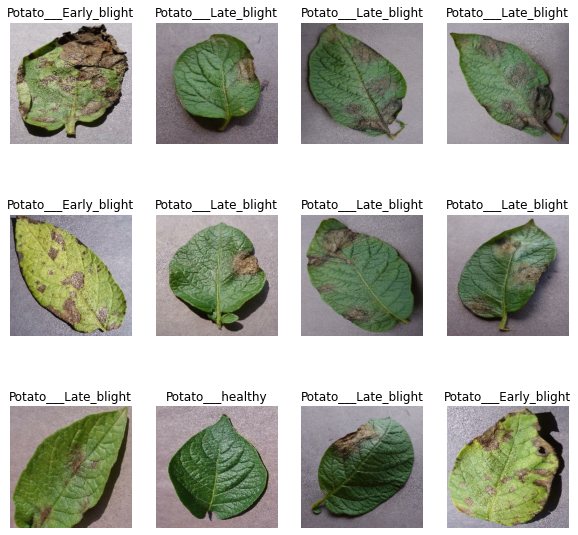

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,1+i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

<b><h>Function to Split Dataset</h></b>

Dataset should be bifurcated into 3 subsets, namely:



1.   Training: Dataset to be used while training.
2.   Validation: Dataset to be tested against while training
3.   Test: Dataset to be tested against after we trained a model




In [ ]:
len(dataset)

68

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert  (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

<b>Cache, Shuffle, and Prefetch the Dataset</b>

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

## Building the Model

**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [152]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Remove 'experimental.preprocessing'
  layers.Rescaling(1.0/255),  # Remove 'experimental.preprocessing'
])

# Data Augmentation


Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),
])

<b>Applying Data Augmentation to Train Dataset</b>

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [150]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Remove BATCH_SIZE from input_shape
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Remove the explicit model.build() call, as it's redundant
# model.build(input_shape=input_shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [147]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9424 - loss: 0.1749 - val_accuracy: 0.9688 - val_loss: 0.0763
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9713 - loss: 0.0824 - val_accuracy: 0.9844 - val_loss: 0.0538
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.9870 - loss: 0.0390 - val_accuracy: 0.9583 - val_loss: 0.0953
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.9685 - loss: 0.0837 - val_accuracy: 0.9427 - val_loss: 0.2064
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9531 - loss: 0.1040 - val_accuracy: 0.9688 - val_loss: 0.1307
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9892 - loss: 0.0276 - val_accuracy: 0.9896 - val_loss: 0.0496
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9900 - loss: 0.0228 - val_accuracy: 0.9896 - val_loss: 0.0528
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9846 - loss: 0.0399 - val_accuracy: 0.9896 - v

In [156]:
# Make sure there's no leading whitespace before this line
drive.flush_and_unmount()

<b>You can see above that we get 95.70% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [159]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<b>Scores is just a list containing loss and accuracy value

In [160]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [161]:
type(history.history['loss'])

list

In [162]:
len(history.history['loss'])

10

In [163]:
history.history['loss'][:5]

[0.1188357025384903,
 0.07172993570566177,
 0.07719133794307709,
 0.08079415559768677,
 0.08813319355249405]

In [164]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## Run prediction on a sample image

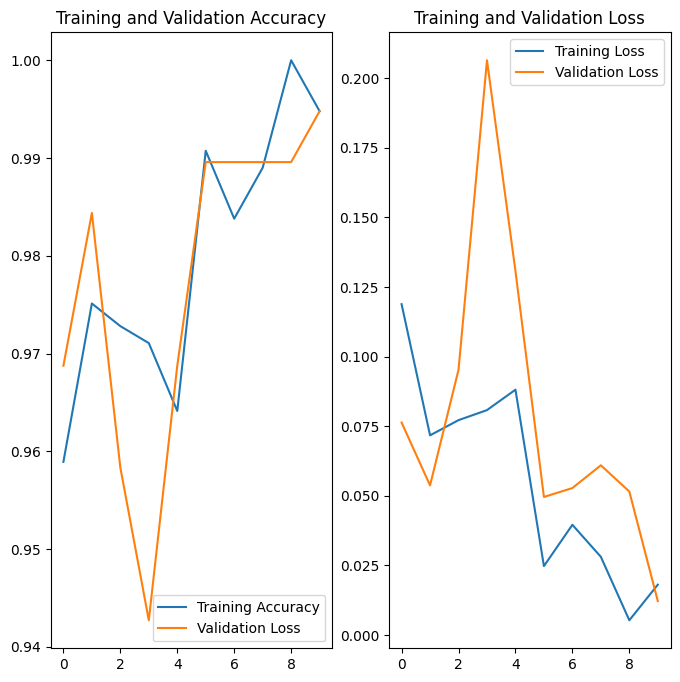

In [165]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [177]:
history.history # Replace 'tu' with this to display the training history

{'accuracy': [0.9589120149612427,
  0.9751157164573669,
  0.9728009104728699,
  0.9710648059844971,
  0.9641203880310059,
  0.9907407164573669,
  0.9837962985038757,
  0.9890046119689941,
  1.0,
  0.9947916865348816],
 'loss': [0.1188357025384903,
  0.07172993570566177,
  0.07719133794307709,
  0.08079415559768677,
  0.08813319355249405,
  0.024773500859737396,
  0.03959999233484268,
  0.028105981647968292,
  0.005312981549650431,
  0.018092472106218338],
 'val_accuracy': [0.96875,
  0.984375,
  0.9583333134651184,
  0.9427083134651184,
  0.96875,
  0.9895833134651184,
  0.9895833134651184,
  0.9895833134651184,
  0.9895833134651184,
  0.9947916865348816],
 'val_loss': [0.0763414278626442,
  0.05375660955905914,
  0.0952850878238678,
  0.20643658936023712,
  0.13073094189167023,
  0.04959851875901222,
  0.05280299484729767,
  0.060973405838012695,
  0.0515592060983181,
  0.01222158968448639]}

## Write a function for inference

In [178]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Now run inference on few sample images

In [182]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive
